# Lab 5: Robust Mixture Models

The goal of this lab session is to study robust mixture models. You will code the EM algorithm to estimate the parameters of a mixture of multivariate t-distributions. 

You have to send the filled notebook named **"L5_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before October 31 at 23:59. Please put **"AML-L5"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from math import *
from scipy.special import digamma
from sklearn.cluster import KMeans
from scipy.optimize import fsolve
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

### $t$MM

Reference: https://people.smp.uq.edu.au/GeoffMcLachlan/pm_sc00.pdf 

1 - Prove that in the $t$MM model

$$U_i|(X_i=x_i,Z_{ij}=1) \sim \Gamma\left(\frac{\nu_j+p}{2}, \frac{\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2}\right)$$


We can notice that the pdf associated to that random variable can be written as follow,

$$f_{U_i|(X_i=x_i,Z_{ij}=1)}(u) =  \frac{f_{U_i}(u)f_{X_i|(U_i=u)}}{f_{X_i}(x_i)} $$
Where:

$f_{U_i}(u) = \frac{{\frac{\nu_j}{2}}^{\frac{\nu_j}{2}}u^{\frac{\nu_j}{2}-1}e^{-\frac{u}{2}\nu_j}}{\Gamma(\frac{\nu_j}{2})} $

$f_{X_i}(x_i)=\frac{\Gamma(\frac{\nu_j+p}{2})|\Sigma_j|^{-1/2}\nu_j^{\frac{\nu_j+p}{2}}}{(\pi\nu_j)^{p/2}\Gamma(\frac{\nu_j}{2})(\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j))^{\frac{\nu_j+p}{2}}} $

$f_{X_i}|(U_i=u)(x_i) = (2\pi)^{-p/2}u^{p/2}|\Sigma_j|^{-1/2}e^{\frac{-u}{2}(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j))}$


After replacing each term in the above formula, we find,
$$f_{U_i|(X_i=x_i,Z_{ij}=1)}(u) = \frac{(\frac{\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2})^{\frac{\nu_j+p}{2}}u^{\frac{\nu_j+p}{2}-1}e^{\frac{-u}{2}(\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j))}}{\Gamma(\frac{\nu_j+p}{2})}$$
Hence, we can conclude :
$$U_i|(X_i=x_i,Z_{ij}=1) \sim \Gamma\left(\frac{\nu_j+p}{2}, \frac{\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2}\right)$$
***

2 - Fill in the following class to implement EM for a multivariate $t$MM. You can use the gamma and digamma functions and also a solver to find roots. 

In [2]:
class my_tMM():
    
    def __init__(self, K,max_iter):
        '''
        Parameters:
        K: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        u_: (n, K) np.array
            expectation of the U variable 
        dof_: (K, ) np.array
            degrees of freedom of each component
        labels_: (n, ) np.array
            labels for data points
        '''
        
        self.K = K
        self.max_iter = max_iter
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.dof_ = None
        self.u_ = None
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        def sqr_mahalanobis(x, mu, Sigma):
            # compute the squared Mahalanobis distance
            return(np.dot(np.transpose(x-mu), np.dot(np.linalg.pinv(Sigma), x-mu)))
        
        def pdf_multivariate_t(X, mu, Sigma, dof):
            # compute pdf of a multivariate Student's t-distribution  
            p= len(mu)
            Num = gamma((p+dof)/2)
            Denom =  gamma(dof/2) * ((dof*np.pi)**(p/2)) * (np.linalg.det(Sigma)**0.5) * (1 + sqr_mahalanobis(X, mu, Sigma)/dof)** ((p+dof)/2)
            d = Num / Denom 
            return(d)
        
        def function_dof(old_dof, cond_prob, u, k, p):
            # function to find dof
            def dof_fun(dof):
              return(-digamma(dof/2)+np.log(dof/2) +1 +digamma((p+old_dof)/2)-np.log((p+old_dof)/2)+(np.dot(cond_prob[:,k],np.log(u[:,k])-u[:,k]))/np.sum(cond_prob[:,k]) )
            return(fsolve(dof_fun, old_dof))
   
            
        # initialization
        n, p = X.shape
        K = self.K
        self.alpha_ = np.zeros((K,))
        self.mu_ = np.zeros((K,p))
        shape = K, p, p
        self.Sigma_ = np.full(shape, np.cov(X, rowvar = False))
        self.cond_prob_ = np.zeros((n,K))
        self.dof_ = 3*np.ones((K,))
        self.u_ = np.zeros((n,K))
        
        
        
        # fit a k-mean clustering to find approximately the means
        kmeans = KMeans(n_clusters=self.K, random_state=0).fit(X)
        labels = kmeans.predict(X)
        unique, count = np.unique(labels,return_counts=True)
        for i in range(K):
            self.mu_[i] = np.mean(X[np.where(labels == i)],axis=0)
            self.alpha_[i] = count[i]/n
        for it in range(self.max_iter):
            #E-step
            for i in range(n):
                for j in range(K):
                    self.u_[i,j] = (self.dof_[j]+p)/(self.dof_[j]+sqr_mahalanobis(X[i],self.mu_[j],self.Sigma_[j]))
                    
                    tw = self.alpha_[j]*pdf_multivariate_t(X[i],self.mu_[j],self.Sigma_[j],self.dof_[j])
    
                    self.cond_prob_[i,j] = tw/np.sum([self.alpha_[j]*pdf_multivariate_t(X[i],self.mu_[j],self.Sigma_[j],self.dof_[j]) for j in range(K)])
            # M-step
            for l in range(K):
                self.alpha_[l] = np.sum(self.cond_prob_[:,l])/n
                Z = [np.sum([self.cond_prob_[i,l]*self.u_[i,l] for i in range(n)]) for l in range(K)]
                self.mu_[l] = np.sum([X[i]*self.cond_prob_[i,l]*self.u_[i,l] for i in range(n)], axis =0)/[np.sum([self.cond_prob_[i,l]*self.u_[i,l] for i in range(n)]) for j in range(p)] 
                temp = np.sum([((X[i]-self.mu_[l]).reshape(-1,1).T*(X[i]-self.mu_[l]).reshape(-1,1))*self.cond_prob_[i,l]**self.u_[i,l] for i in range(n)], axis=0)/[np.sum([self.cond_prob_[i,l] for i in range(n)]) for j in range(p)]
                self.Sigma_[l] = temp
                self.dof_[l] = function_dof(self.dof_[l], self.cond_prob_, self.u_, l, p)
            
        
        self.labels_ = np.array([np.argmax(self.cond_prob_[i,:]) for i in range(n)])            
        return self
            

In [3]:
class my_GMM():
    
    def __init__(self, k, num_iter):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.num_iter = num_iter
        self.alpha_ = None
        self.mu_ = None
        self.sigma_ = None
        self.cond_prob = None
        self.labels = None
        self.P= None
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        np.random.seed(seed=3)
        self.alpha_ = np.ones(self.k)/self.k
        self.mu_ = 10*(np.random.rand(self.k,np.shape(X)[1])-0.5)
        self.sigma_ = np.random.rand(self.k,np.shape(X)[1],np.shape(X)[1])
        for i in range(self.k):
            self.sigma_[i]=.2+np.diag(100*np.random.rand(np.shape(X)[1]))
        N= np.shape(X)[0]
        K=self.k   
        for t in range(self.num_iter):
            P= np.zeros((N, K))
            for i in range(N):
                S=0
                for l in range(K):
                    S+= self.alpha_[l]* scipy.stats.multivariate_normal.pdf(X[i],self.mu_[l],self.sigma_[l],allow_singular=True)
                for j in range(K):
                    P[i][j]=(self.alpha_[j]* scipy.stats.multivariate_normal.pdf(X[i],self.mu_[j],self.sigma_[j],allow_singular=True))/S 
            self.alpha_= np.sum(P, axis = 0)/ N
            for j in range(K):
                self.mu_[j,:]= np.sum(X*np.expand_dims(P[:,j],axis=1), axis=0)/(N* self.alpha_[j])#
            for j in range(K):
                A= np.zeros((np.shape(X)[1],np.shape(X)[1]), dtype= "Float64")
                for i in range(N):
                    A= A+ P[i,j]*np.dot(np.expand_dims((X[i]-self.mu_[j]).T, axis=1),np.expand_dims(X[i]-self.mu_[j], axis=0))
                self.sigma_[j]= A/(N* self.alpha_[j])#
        self.P= P
        return( self.alpha_, self.mu_, self.sigma_ , np.shape(self.P))
            
            
            
        def compute_condition_prob_matrix(X, alpha, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
        
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        
        # While not(convergence)
        #     Compute conditional probability matrix
        #     Update parameters
        
        # Update labels_
        
        # Return self
        N= np.shape(X)[0]
        K=self.k   
        self.P= np.zeros((N, K))
        for i in range(N):
            S=0
            for l in range(K):
                S+= alpha[l]* scipy.stats.multivariate_normal.pdf(X[i],mu[l],Sigma[l],allow_singular=True)
            for j in range(K):
                self.P[i][j]=(alpha[j]* scipy.stats.multivariate_normal.pdf(X[i],mu[j],Sigma[j],allow_singular=True))/S 
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        N= np.shape(X)[0]
        K=self.k 
        self.labels= np.zeros((N,1))
        for i in range(N):
            self.labels[i]=np.random.choice(np.arange(1, K+1), p=self.P[i])
        return(self.labels)
        
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        return self.P

3 - Generate one dataset with mixtures of t-distributions that ilustrate when tMM and GMM behave similarly and another dataset where tMM has a better performance

Text(0.5, 1.0, 'noisy data')

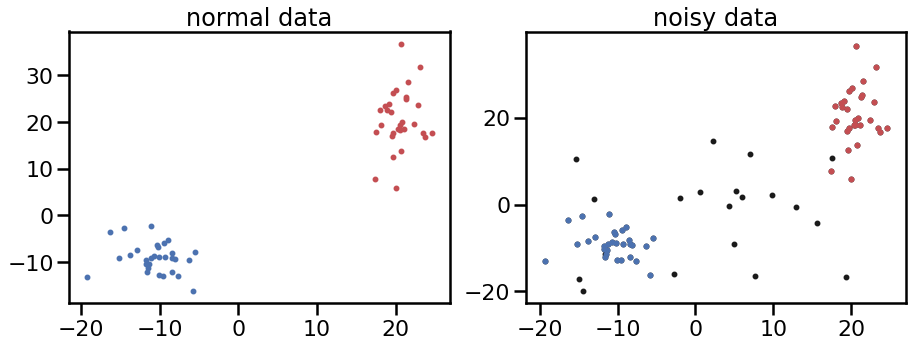

In [4]:
np.random.seed(seed=3)
def multivariatet(mu,Sigma,N,M):
    '''
    Output:
    Produce M samples of d-dimensional multivariate t distribution
    Input:
    mu = mean (d dimensional numpy array or scalar)
    Sigma = scale matrix (dxd numpy array)
    N = degrees of freedom
    M = # of samples to produce
    '''
    d = len(Sigma)
    g = np.tile(np.random.gamma(N/2.,2./N,M),(d,1)).T
    Z = np.random.multivariate_normal(np.zeros(d),Sigma,M)
    return mu + Z/np.sqrt(g)
X_1=multivariatet(-10,[[5,0],[0,5]],5,30)
X_2=multivariatet(20,[[5,0],[0,25]],10,30)
X= np.concatenate((X_1,X_2))
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(X_1[:,0],X_1[:,1],color='b',s=15)
ax[0].scatter(X_2[:,0],X_2[:,1],color='r',s=15)
ax[0].set_title('normal data')
#ax[0].scatter(X_2[:,0],X_2[:,1])

n = 20
xy_min = [-20, -20]
xy_max = [20, 20]
data_n = np.random.uniform(low=xy_min, high=xy_max, size=(n,2))
X_n= np.concatenate((X,data_n))
ax[1].scatter(X_n[:,0],X_n[:,1],color='k',s=15)
ax[1].scatter(X_1[:,0],X_1[:,1],color='b',s=15)
ax[1].scatter(X_2[:,0],X_2[:,1],color='r',s=15)


ax[1].set_title('noisy data')

/home/hrami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


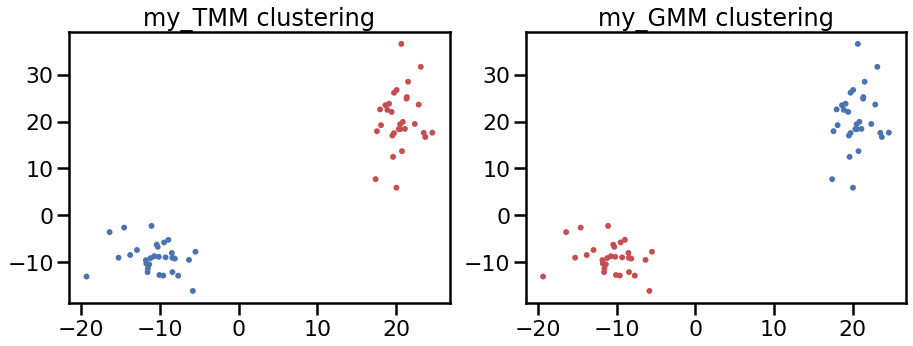

In [5]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
model = my_tMM(K=2, max_iter=100)
model.fit(X)
labels= model.labels_
colormap = np.array(['r', 'b'])
ax[0].scatter(X[:,0], X[:,1], c=colormap[labels],s=15)
model = my_GMM(k=2,num_iter=100)
model.fit(X)
labels= model.predict(X)
colormap = np.array(['r', 'b'])
ax[1].scatter(X[:,0], X[:,1], c=colormap[np.array(labels.T, dtype="int32")[0]-1],s=15)
ax[0].set_title('my_TMM clustering')
ax[1].set_title('my_GMM clustering')
plt.show()

    We can notice that in this case my_GMM and my_TMM behave similarly

/home/hrami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


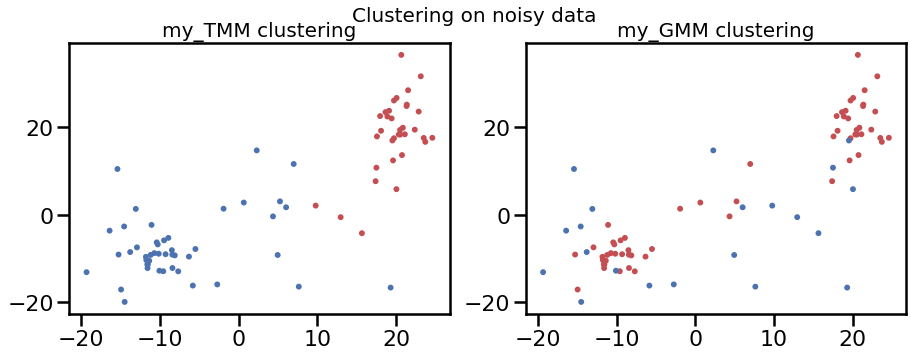

In [6]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
model = my_tMM(K=2, max_iter=100)
model.fit(X_n)
labels= model.labels_
colormap = np.array(['r', 'b'])
ax[0].scatter(X_n[:,0], X_n[:,1], c=colormap[labels],s=15)
model = my_GMM(k=2,num_iter=100)
model.fit(X_n)
labels= model.predict(X_n)
colormap = np.array(['r', 'b'])
ax[1].scatter(X_n[:,0], X_n[:,1], c=colormap[np.array(labels.T, dtype="int32")[0]-1],s=15)
ax[0].set_title('my_TMM clustering',fontsize=20)
ax[1].set_title('my_GMM clustering',fontsize=20)
plt.suptitle('Clustering on noisy data',fontsize=20)
plt.show()

    We can notice that in the case of noisy data, my_TMM performs better than my_GMM because it's not sensible       to noise. One way to solve this problem is to add an Extra Uniform Cluster that contains noisy points (See below)

4 - Modify the my_GMM class to implement the Extra Uniform Cluster Algorithm

In [7]:
class my_GMM_2():
    
    def __init__(self, k, num_iter):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.num_iter = num_iter
        self.alpha_ = None
        self.mu_ = None
        self.sigma_ = None
        self.cond_prob = None
        self.labels = None
        self.P= None
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        np.random.seed(seed=3)
        self.alpha_ = np.ones(self.k+1)/self.k+1
        self.mu_ = 10*(np.random.rand(self.k,np.shape(X)[1])-0.5)
        self.sigma_ = np.random.rand(self.k,np.shape(X)[1],np.shape(X)[1])
        for i in range(self.k):
            self.sigma_[i]=np.diag(100*np.random.rand(np.shape(X)[1]))
        N= np.shape(X)[0]
        K=self.k   
        V=1/((X[:,0].max()-X[:,0].min())*X[:,1].max()-X[:,1].min())
        for t in range(self.num_iter):
            P= np.zeros((N, K+1))
            for i in range(N):
                S=0
                for l in range(K):
                    S+= self.alpha_[l]* scipy.stats.multivariate_normal.pdf(X[i],self.mu_[l],self.sigma_[l],allow_singular=True)
                S+=self.alpha_[K]*V
                for j in range(K):
                    P[i][j]=(self.alpha_[j]* scipy.stats.multivariate_normal.pdf(X[i],self.mu_[j],self.sigma_[j],allow_singular=True))/S
                P[i][K]=(self.alpha_[K]*V)/S
            self.alpha_= np.sum(P, axis = 0)/ N
            for j in range(K):
                self.mu_[j,:]= np.sum(X*np.expand_dims(P[:,j],axis=1), axis=0)/(N* self.alpha_[j])#
            for j in range(K):
                A= np.zeros((np.shape(X)[1],np.shape(X)[1]), dtype= "Float64")
                for i in range(N):
                    A= A+ P[i,j]*np.dot(np.expand_dims((X[i]-self.mu_[j]).T, axis=1),np.expand_dims(X[i]-self.mu_[j], axis=0))
                self.sigma_[j]= A/(N* self.alpha_[j])#
        self.P= P
        return( self.alpha_, self.mu_, self.sigma_ , np.shape(self.P))
            
            
            
        def compute_condition_prob_matrix(X, alpha, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
        N= np.shape(X)[0]
        K=self.k   
        self.P= np.zeros((N, K))
        for i in range(N):
            S=0
            for l in range(K):
                S+= alpha[l]* scipy.stats.multivariate_normal.pdf(X[i],mu[l],Sigma[l],allow_singular=True)
            for j in range(K):
                self.P[i][j]=(alpha[j]* scipy.stats.multivariate_normal.pdf(X[i],mu[j],Sigma[j],allow_singular=True))/S 
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        N= np.shape(X)[0]
        K=self.k 
        self.labels= np.zeros((N,1))
        for i in range(N):
            self.labels[i]=np.random.choice(np.arange(1, K+2), p=self.P[i])
        return(self.labels)
        
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        return self.P

6 - Compare the 3 methods in one example

/home/hrami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/home/hrami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


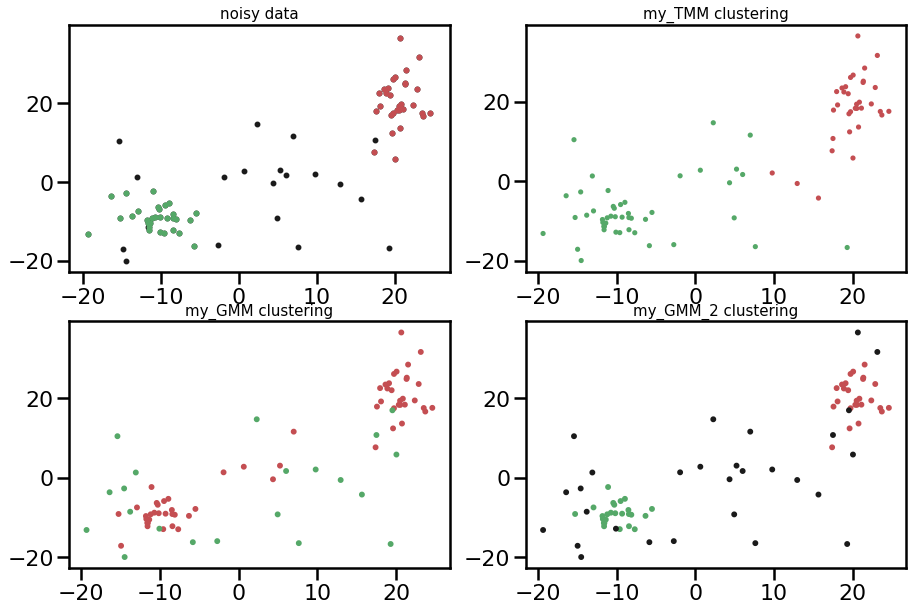

In [8]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ax[0,0].scatter(X_n[:,0],X_n[:,1],color='k',s=15)
ax[0,0].scatter(X_1[:,0],X_1[:,1],color='g',s=15)
ax[0,0].scatter(X_2[:,0],X_2[:,1],color='r',s=15)
ax[0,0].set_title('noisy data',fontsize=15)


model = my_tMM(K=2, max_iter=100)
model.fit(X_n)
labels= model.labels_
colormap = np.array(['r', 'g'])
ax[0,1].scatter(X_n[:,0], X_n[:,1], c=colormap[labels],s=10)


model = my_GMM(k=2,num_iter=100)
model.fit(X_n)
labels= model.predict(X_n)
colormap = np.array(['r', 'g'])
ax[1,0].scatter(X_n[:,0], X_n[:,1], c=colormap[np.array(labels.T, dtype="int32")[0]-1],s=15)


model = my_GMM_2(k=2,num_iter=100)
model.fit(X_n)
labels= model.predict(X_n)
colormap = np.array(['r', 'g','k'])
ax[1,1].scatter(X_n[:,0], X_n[:,1], c=colormap[np.array(labels.T, dtype="int32")[0]-1],s=15)

ax[0,1].set_title('my_TMM clustering',fontsize=15)
ax[1,0].set_title('my_GMM clustering',fontsize=15)
ax[1,1].set_title('my_GMM_2 clustering',fontsize=15)

plt.show()

    As we can see in the last plot, we managed to add an Extra Uniform cluster that contains almost all the noise           data from the original one;